In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

from data_manipulation.reading_util import load_and_extract_2nd_class

load_dotenv()


2023-10-01 17:12:43.354903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 17:12:43.392319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 17:12:43.393333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 17:12:44.151491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

In [2]:
emb_path = os.getenv("ESM2_ENZYMES_SPLIT_100")
csv_path = os.getenv("CSV100_ENZYMES")
wanted_ec = 7

# Extracting 2nd ec class form wanted main class
----

LOG: 26 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split100.csv
LOG: 174 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split100.csv
LOG: 4532 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split100.csv
LOG: 4732 entries will be ignored
LOG: Data loaded in: 31.295 min
LOG: ESM2 of enzymes: 8070
LOG: Labels of enzymes: 8070


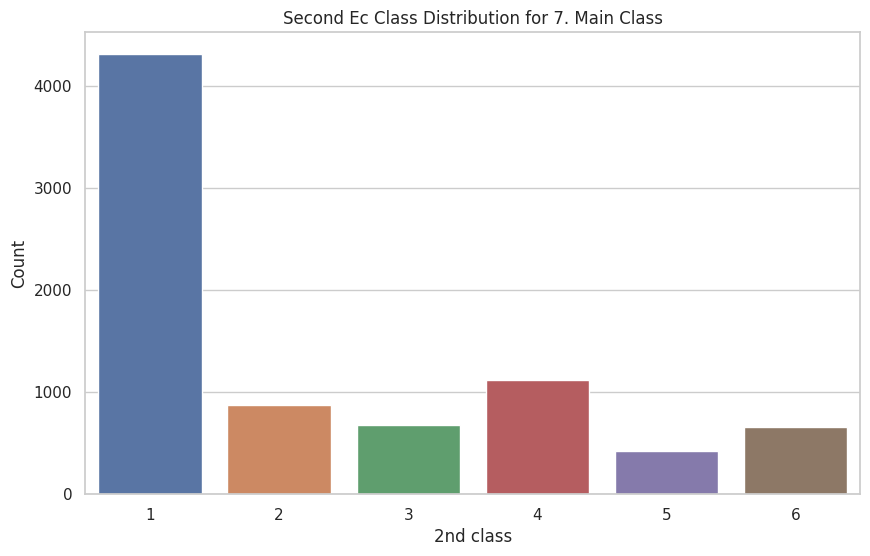

In [3]:
X, y, sec_to_label, label_to_sec = load_and_extract_2nd_class(path_to_esm2=emb_path,
                                                              path_to_enzyme_csv=csv_path,
                                                              wanted_ec_class=wanted_ec)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)
plt.xticks(list(label_to_sec.keys()), list(sec_to_label.keys()))

# Add labels and title
plt.xlabel("2nd class")
plt.ylabel("Count")
plt.title(f"Second Ec Class Distribution for {wanted_ec}. Main Class")

# Show the plot
plt.show()


In [4]:
print(sec_to_label)
print(label_to_sec)


{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}


# Training a CNN based on amount of y_labels
----

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(sec_to_label))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(sec_to_label))


In [6]:
print(y_test_encoded[0])


[1. 0. 0. 0. 0. 0.]


In [7]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=3)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=len(sec_to_label), activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [8]:
model.fit(x=X_train, y=y_train_encoded, epochs=30, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/30
190/190 [==============================] - 3s 11ms/step - loss: 0.5995 - val_loss: 0.1910
Epoch 2/30
190/190 [==============================] - 2s 10ms/step - loss: 0.1921 - val_loss: 0.0810
Epoch 3/30
190/190 [==============================] - 2s 10ms/step - loss: 0.1141 - val_loss: 0.0589
Epoch 4/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0814 - val_loss: 0.0511
Epoch 5/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0780 - val_loss: 0.0397
Epoch 6/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0582 - val_loss: 0.0387
Epoch 7/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0419 - val_loss: 0.0395
Epoch 8/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0511 - val_loss: 0.0402
Epoch 9/30
190/190 [==============================] - 2s 10ms/step - loss: 0.0467 - val_loss: 0.0339
Epoch 10/30
190/190 [==============================] - 2s 11ms/step - loss: 0.0362 - val_lo

<Figure size 1000x600 with 0 Axes>

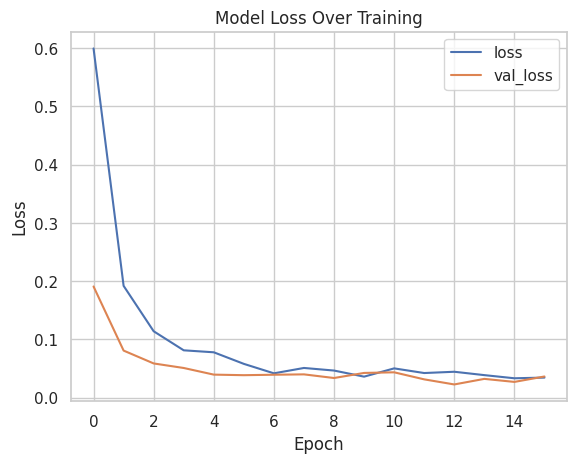

In [10]:
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [11]:
predictions = np.argmax(model.predict(X_test), axis=-1) 

64/64 [==============================] - 0s 3ms/step


In [12]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1101
           1       0.98      0.97      0.98       212
           2       1.00      0.99      0.99       155
           3       1.00      0.98      0.99       284
           4       0.97      1.00      0.99       115
           5       0.94      0.98      0.96       151

    accuracy                           0.99      2018
   macro avg       0.98      0.99      0.98      2018
weighted avg       0.99      0.99      0.99      2018


In [13]:
def plot_report(report, y, predictions):
    """
    Plots results of model
    :param report: Report of model
    """
    metrics = [] 
    for i in range(len(label_to_sec)):
        metrics.append(report.split('\n')[i+2].split()[1:])

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        if len(class_m) != 0:
            precision = float(class_m[0])
            recall = float(class_m[1])
            f1_score = float(class_m[2])
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)
        else:
            precision = 0
            recall = 0
            f1_score = 0
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)
            

    class_names = list(sec_to_label.values())

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_xticks(list(label_to_sec.keys()))
    ax1.set_xticklabels(list(sec_to_label.keys()), rotation=90)
    ax1.set_title("Recall")
    ax1.set_xlabel("2nd EC Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_xticks(list(label_to_sec.keys()))
    ax2.set_xticklabels(list(sec_to_label.keys()), rotation=90)
    ax2.set_title("Precision")
    ax2.set_xlabel("2nd EC Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_xticks(list(label_to_sec.keys()))
    ax3.set_xticklabels(list(sec_to_label.keys()), rotation=90)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("2nd EC Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(sec_to_label.keys()), yticklabels=list(sec_to_label.keys()))
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.title("Confusion Matrix")
    plt.show()


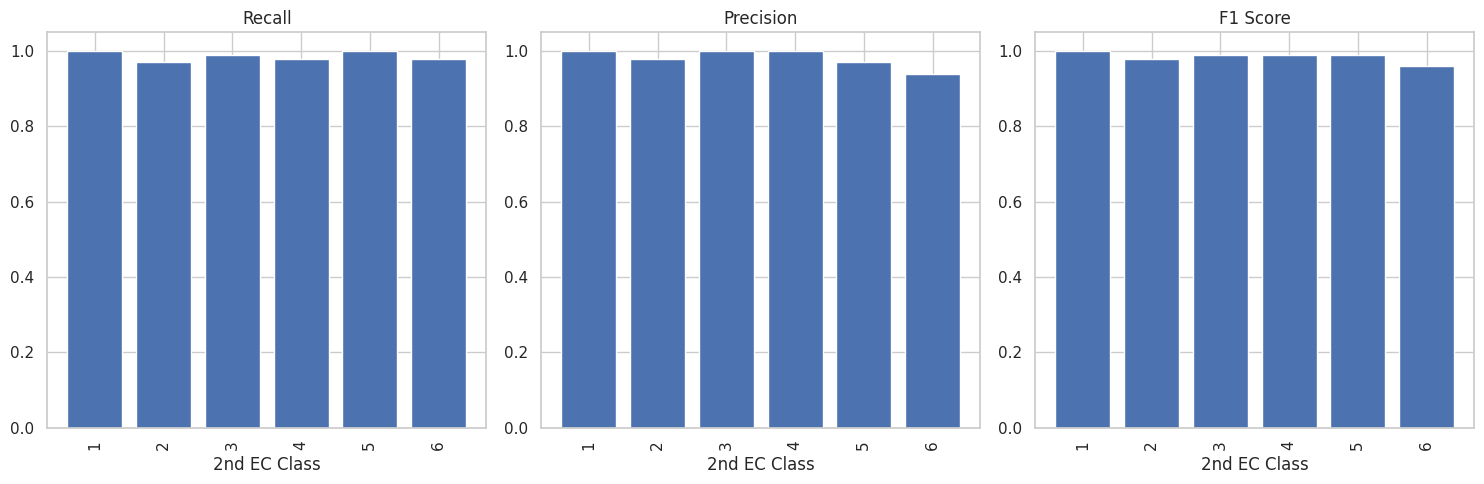

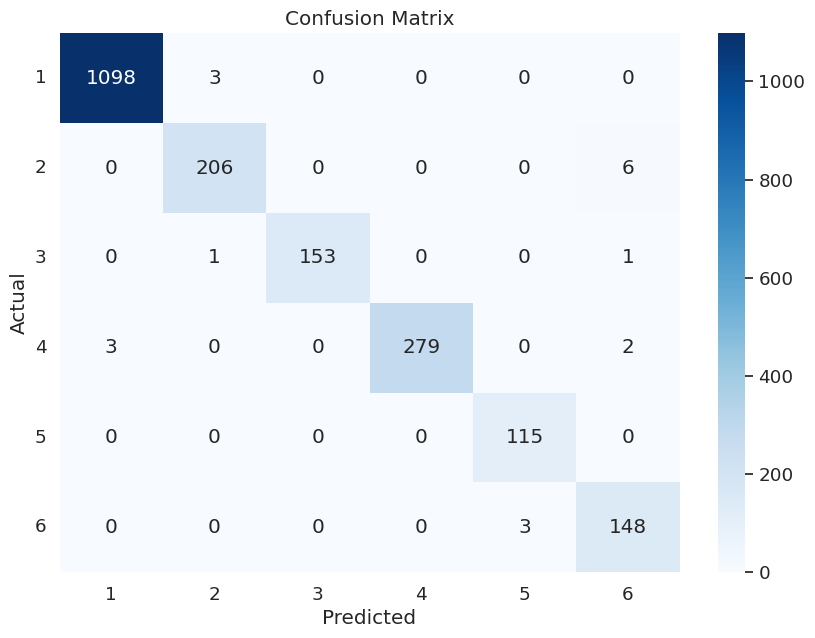

In [14]:
plot_report(report=report, y=y_test, predictions=predictions)

In [15]:
tf.keras.models.save_model(model, "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/class_7_s100.keras")

